In [1]:
import os,shutil
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
from tqdm import tqdm

In [2]:
## use gdown in google collab to download training data. 
# !gdown --id '1zg5EDls7E4ZnkWzPKh_XNkw564ns22mq'

In [3]:
class pavement_data(Dataset):
    def __init__(self, root_dir, csv_path):
        self.root = Path(root_dir)

        self.df = pd.read_csv(os.path.join(root_dir,csv_path))
        self.df = self.df.sample(frac=1)
        self.image_names = [os.path.join(self.root,'train',i) for i in self.df['image_name'].values]
        self.pci_label = list(self.df['pci'].values)

    def __len__(self):
        # returns the length of the dataset
        return len(self.image_names)

    def __getitem__(self, idx):

    #     # preprocess and transformations
    #     # indexes the dataset such that dataset[i] can retrieve the ith sample.
        image = self.image_names[idx]
        # print (image)
        if os.path.isfile(image):
            image_data = io.imread(image)
            # print (image_data)

            label = self.pci_label[idx]

            sample = {'image': image_data, 'image_path':image,'label': label}

            return sample

In [4]:
pavement_dataset = pavement_data('../../data','train.csv')

In [5]:
for idx, sample in enumerate(pavement_dataset):
    print (sample['image'].shape, sample['label'])

    if idx == 5:
        break

(224, 224, 3) 48
(224, 224, 3) 40
(224, 224, 3) 93
(224, 224, 3) 100
(224, 224, 3) 100
(224, 224, 3) 60


In [6]:
def plot_data(pavement_dataset,cls_thresh,num_samples):
  fig = plt.figure(figsize=(20,20))
  ncols = int(np.floor(num_samples/2))+1
  cnt = 0
  df = pavement_dataset.df
  df['image_names'] = pavement_dataset.image_names
  df = df[df['pci'].between(cls_thresh[0],cls_thresh[1])]
  df = df.sample(frac=1)
  df = df.reset_index()
  
  fig, axs = plt.subplots(2, ncols, figsize=(20, 10))

  for i, sample in df.iterrows():
    plt.tight_layout()
    axs[int(i/ncols), (i%ncols)].set_title('Sample PCI - {}'.format(sample['pci']))
    axs[int(i/ncols), (i%ncols)].imshow(io.imread(sample['image_names']))
    axs[int(i/ncols), (i%ncols)].axis('off')
    if i+1 == ncols*2:
      plt.show()
      break
  plt.show()

<Figure size 2000x2000 with 0 Axes>

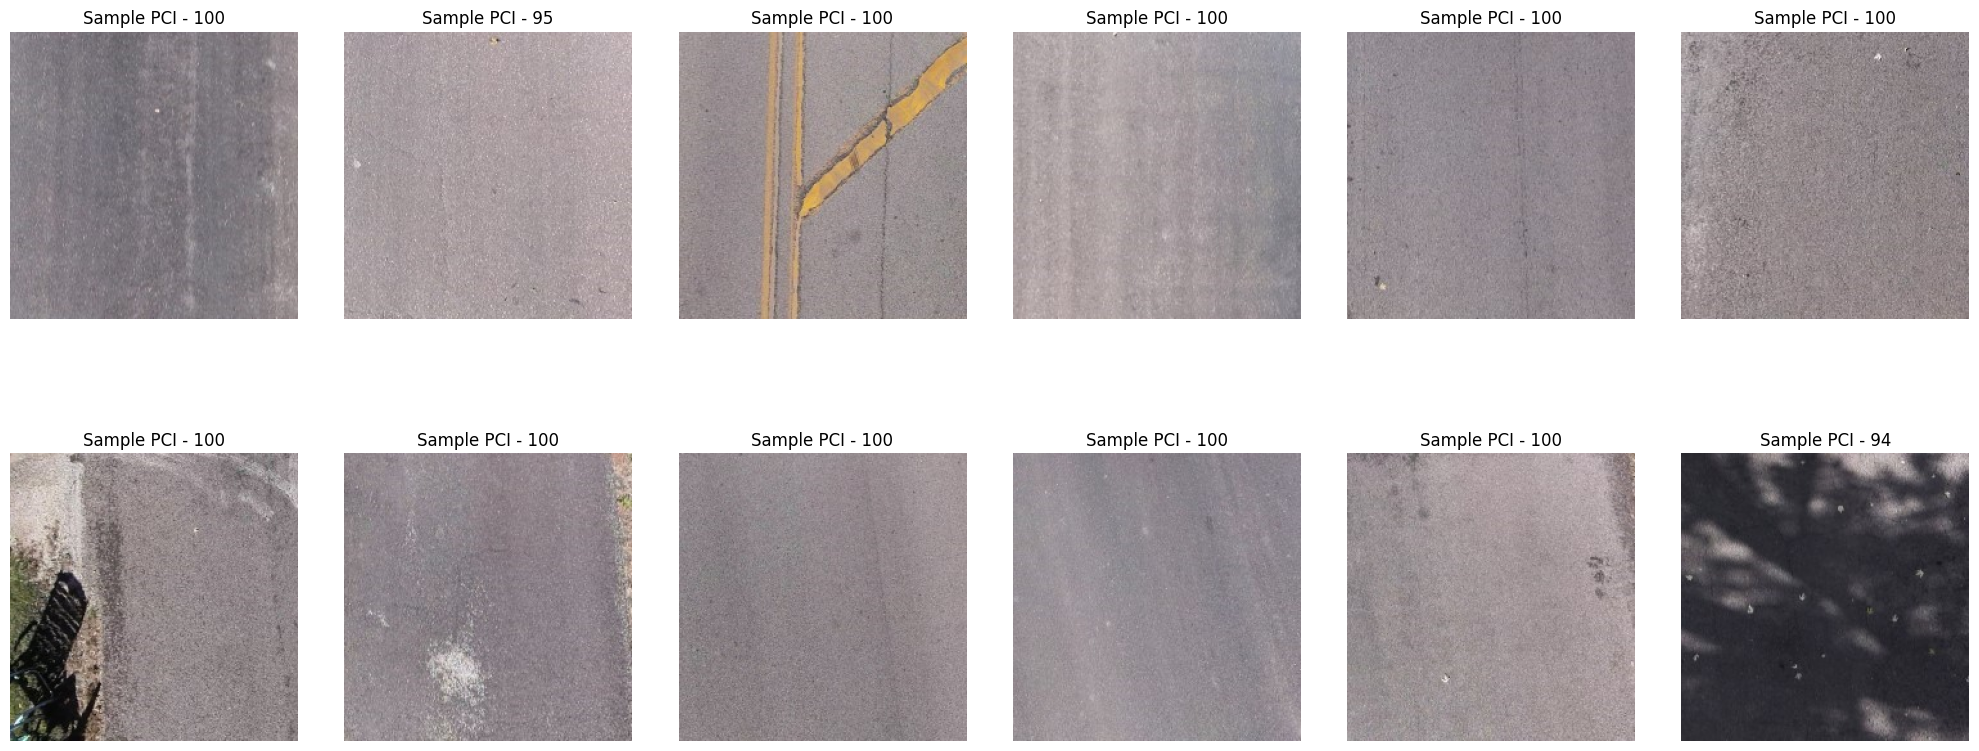

In [7]:
plot_data(pavement_dataset,(90,100),10)

In [8]:
class prep_data(object):
  def __init__(self,root_dir,csv_path):
    self.root = Path(root_dir)
    self.df = pd.read_csv(os.path.join(root_dir,csv_path))
    self.image_names = [os.path.join(self.root,'train',i) for i in self.df['image_name'].values]
    self.pci_label = list(self.df['pci'].values)
    self.train_folder = os.path.join(root_dir,'yolov8','train')
    self.val_folder = os.path.join(root_dir,'yolov8','val')
    Path(self.train_folder).mkdir(parents=True, exist_ok=True)
    Path(self.val_folder).mkdir(parents=True, exist_ok=True)

  def __call__(self,sample, testelemnt=False):
    if not sample is None:
      _, img_path, labels = sample['image'],sample['image_path'], sample['label']
      folder = self.train_folder if not testelemnt else self.val_folder
      dst_folder = os.path.join(folder,str(labels))
      Path(dst_folder).mkdir(parents=True, exist_ok=True)
      fname = os.path.basename(img_path)
      if not os.path.isfile(os.path.join(dst_folder,fname)):
        shutil.copy2(img_path,dst_folder)

In [9]:
obj_prep = prep_data('../../data','train.csv')

In [10]:
for i, sample in enumerate(tqdm(pavement_dataset)):
    obj_prep(sample, i % 5 == 0)        

100%|██████████| 7704/7704 [00:53<00:00, 144.93it/s]


In [11]:
from ultralytics import YOLO

In [12]:
model = YOLO('yolov8n-cls.pt')
# model = YOLO('runs/classify/train3/weights/last.pt')
# model.train(data='dsps/yolov8', epochs=100)
model.train(data='../../data/yolov8', epochs=100)

Ultralytics YOLOv8.1.11 🚀 Python-3.11.5 torch-2.1.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 16384MiB)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=../../data/yolov8, epochs=100, time=None, patience=50, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

train: Scanning C:\Users\alex\OneDrive\Documents\GitHub\DSPS24\data\yolov8\train... 6161 images, 0 corrupt: 100%|██████████| 6161/6161 [00:07<00:00, 856.60it/s]


train: New cache created: C:\Users\alex\OneDrive\Documents\GitHub\DSPS24\data\yolov8\train.cache


val: Scanning C:\Users\alex\OneDrive\Documents\GitHub\DSPS24\data\yolov8\val... 1541 images, 0 corrupt: 100%|██████████| 1541/1541 [00:02<00:00, 767.07it/s]


val: New cache created: C:\Users\alex\OneDrive\Documents\GitHub\DSPS24\data\yolov8\val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to c:\Users\alex\OneDrive\Documents\GitHub\DSPS24\runs\classify\train
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100     0.543G      4.632         16        224:   6%|▌         | 23/386 [00:02<00:22, 16.39it/s]

100%|██████████| 755k/755k [00:00<00:00, 3.17MB/s]  224:  15%|█▌        | 59/386 [00:04<00:18, 17.81it/s]
      1/100     0.547G      3.581          1        224: 100%|██████████| 386/386 [00:20<00:00, 18.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 33.81it/s]

                   all    0.00195     0.0227



      Epoch    GPU_mem       loss  Instances       Size


      2/100     0.528G       3.03          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 43.90it/s]

                   all    0.00195     0.0292



      Epoch    GPU_mem       loss  Instances       Size


      3/100     0.528G      2.886          1        224: 100%|██████████| 386/386 [00:16<00:00, 24.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 42.38it/s]


                   all    0.00324     0.0311

      Epoch    GPU_mem       loss  Instances       Size


      4/100     0.528G      2.809          1        224: 100%|██████████| 386/386 [00:15<00:00, 24.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.68it/s]

                   all    0.00389     0.0363



      Epoch    GPU_mem       loss  Instances       Size


      5/100     0.528G      2.699          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.90it/s]

                   all    0.00389      0.026



      Epoch    GPU_mem       loss  Instances       Size


      6/100     0.528G      2.636          1        224: 100%|██████████| 386/386 [00:15<00:00, 24.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.85it/s]

                   all     0.0026     0.0279



      Epoch    GPU_mem       loss  Instances       Size


      7/100     0.528G      2.562          1        224: 100%|██████████| 386/386 [00:19<00:00, 20.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 36.14it/s]

                   all    0.00519      0.037



      Epoch    GPU_mem       loss  Instances       Size


      8/100     0.528G      2.481          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 39.05it/s]

                   all    0.00324     0.0279



      Epoch    GPU_mem       loss  Instances       Size


      9/100     0.528G      2.405          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.79it/s]

                   all    0.00584      0.037



      Epoch    GPU_mem       loss  Instances       Size


     10/100     0.528G      2.368          1        224: 100%|██████████| 386/386 [00:17<00:00, 22.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.41it/s]

                   all    0.00454     0.0467



      Epoch    GPU_mem       loss  Instances       Size


     11/100     0.528G      2.319          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.50it/s]

                   all    0.00519     0.0363



      Epoch    GPU_mem       loss  Instances       Size


     12/100     0.528G      2.247          1        224: 100%|██████████| 386/386 [00:16<00:00, 22.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.51it/s]


                   all    0.00389     0.0324

      Epoch    GPU_mem       loss  Instances       Size


     13/100     0.528G      2.232          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.81it/s]

                   all    0.00584     0.0363



      Epoch    GPU_mem       loss  Instances       Size


     14/100     0.528G      2.164          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.28it/s]

                   all    0.00649     0.0389



      Epoch    GPU_mem       loss  Instances       Size


     15/100     0.528G      2.132          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.81it/s]

                   all    0.00714     0.0474



      Epoch    GPU_mem       loss  Instances       Size


     16/100     0.528G      2.072          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.49it/s]

                   all    0.00519     0.0363



      Epoch    GPU_mem       loss  Instances       Size


     17/100     0.528G      2.035          1        224: 100%|██████████| 386/386 [00:16<00:00, 22.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.09it/s]

                   all    0.00454      0.035



      Epoch    GPU_mem       loss  Instances       Size


     18/100     0.528G      1.992          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 39.60it/s]

                   all    0.00649     0.0441



      Epoch    GPU_mem       loss  Instances       Size


     19/100     0.528G       1.94          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.18it/s]

                   all    0.00389     0.0441



      Epoch    GPU_mem       loss  Instances       Size


     20/100     0.528G      1.895          1        224: 100%|██████████| 386/386 [00:17<00:00, 22.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 36.62it/s]

                   all    0.00519     0.0441



      Epoch    GPU_mem       loss  Instances       Size


     21/100     0.528G      1.857          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.50it/s]

                   all    0.00389      0.037



      Epoch    GPU_mem       loss  Instances       Size


     22/100     0.528G      1.843          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.76it/s]

                   all    0.00454     0.0402



      Epoch    GPU_mem       loss  Instances       Size


     23/100     0.528G      1.783          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 38.92it/s]

                   all    0.00714     0.0402



      Epoch    GPU_mem       loss  Instances       Size


     24/100     0.528G      1.748          1        224: 100%|██████████| 386/386 [00:17<00:00, 22.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.84it/s]

                   all     0.0104     0.0435



      Epoch    GPU_mem       loss  Instances       Size


     25/100     0.528G      1.719          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 39.92it/s]

                   all    0.00714     0.0376



      Epoch    GPU_mem       loss  Instances       Size


     26/100     0.528G      1.677          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 42.56it/s]

                   all    0.00454     0.0389



      Epoch    GPU_mem       loss  Instances       Size


     27/100     0.528G      1.659          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.12it/s]


                   all    0.00454     0.0409

      Epoch    GPU_mem       loss  Instances       Size


     28/100     0.528G      1.619          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 42.30it/s]


                   all    0.00649     0.0409

      Epoch    GPU_mem       loss  Instances       Size


     29/100     0.528G      1.607          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.63it/s]

                   all    0.00584      0.035



      Epoch    GPU_mem       loss  Instances       Size


     30/100     0.528G      1.539          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.26it/s]


                   all    0.00584     0.0389

      Epoch    GPU_mem       loss  Instances       Size


     31/100     0.528G      1.555          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.45it/s]

                   all    0.00324     0.0324



      Epoch    GPU_mem       loss  Instances       Size


     32/100     0.528G      1.498          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 42.88it/s]

                   all    0.00649     0.0461



      Epoch    GPU_mem       loss  Instances       Size


     33/100     0.528G      1.461          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 39.05it/s]

                   all    0.00584     0.0396



      Epoch    GPU_mem       loss  Instances       Size


     34/100     0.528G      1.456          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.92it/s]

                   all    0.00649     0.0415



      Epoch    GPU_mem       loss  Instances       Size


     35/100     0.528G      1.418          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.34it/s]

                   all    0.00714     0.0422



      Epoch    GPU_mem       loss  Instances       Size


     36/100     0.528G      1.395          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 42.18it/s]

                   all    0.00584     0.0402



      Epoch    GPU_mem       loss  Instances       Size


     37/100     0.528G       1.38          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 39.79it/s]

                   all    0.00779     0.0344



      Epoch    GPU_mem       loss  Instances       Size


     38/100     0.528G      1.365          1        224: 100%|██████████| 386/386 [00:16<00:00, 22.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 37.89it/s]

                   all    0.00584     0.0428



      Epoch    GPU_mem       loss  Instances       Size


     39/100     0.528G      1.333          1        224: 100%|██████████| 386/386 [00:17<00:00, 21.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 38.88it/s]

                   all    0.00389     0.0376



      Epoch    GPU_mem       loss  Instances       Size


     40/100     0.528G      1.289          1        224: 100%|██████████| 386/386 [00:17<00:00, 21.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 38.13it/s]

                   all    0.00649     0.0363



      Epoch    GPU_mem       loss  Instances       Size


     41/100     0.528G       1.27          1        224: 100%|██████████| 386/386 [00:19<00:00, 20.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 38.44it/s]

                   all    0.00454     0.0389



      Epoch    GPU_mem       loss  Instances       Size


     42/100     0.528G      1.257          1        224: 100%|██████████| 386/386 [00:18<00:00, 21.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 38.94it/s]

                   all    0.00454     0.0383



      Epoch    GPU_mem       loss  Instances       Size


     43/100     0.528G      1.238          1        224: 100%|██████████| 386/386 [00:17<00:00, 22.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 39.54it/s]

                   all    0.00584      0.035



      Epoch    GPU_mem       loss  Instances       Size


     44/100     0.528G      1.204          1        224: 100%|██████████| 386/386 [00:17<00:00, 22.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 39.65it/s]

                   all    0.00389     0.0396



      Epoch    GPU_mem       loss  Instances       Size


     45/100     0.528G      1.202          1        224: 100%|██████████| 386/386 [00:17<00:00, 22.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.49it/s]

                   all    0.00649      0.035



      Epoch    GPU_mem       loss  Instances       Size


     46/100     0.528G      1.187          1        224: 100%|██████████| 386/386 [00:16<00:00, 22.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 39.95it/s]

                   all    0.00389     0.0383



      Epoch    GPU_mem       loss  Instances       Size


     47/100     0.528G      1.148          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 42.26it/s]

                   all    0.00519     0.0409



      Epoch    GPU_mem       loss  Instances       Size


     48/100     0.528G      1.116          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.25it/s]

                   all    0.00324      0.035



      Epoch    GPU_mem       loss  Instances       Size


     49/100     0.528G      1.113          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 42.86it/s]

                   all    0.00779     0.0376



      Epoch    GPU_mem       loss  Instances       Size


     50/100     0.528G      1.081          1        224: 100%|██████████| 386/386 [00:17<00:00, 21.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.03it/s]

                   all    0.00584     0.0363



      Epoch    GPU_mem       loss  Instances       Size


     51/100     0.528G      1.085          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.20it/s]


                   all    0.00714     0.0383

      Epoch    GPU_mem       loss  Instances       Size


     52/100     0.528G       1.07          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.64it/s]

                   all    0.00649     0.0383



      Epoch    GPU_mem       loss  Instances       Size


     53/100     0.528G       1.05          1        224: 100%|██████████| 386/386 [00:18<00:00, 20.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.90it/s]

                   all    0.00779     0.0389



      Epoch    GPU_mem       loss  Instances       Size


     54/100     0.528G      1.012          1        224: 100%|██████████| 386/386 [00:18<00:00, 21.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 34.88it/s]

                   all    0.00584     0.0337



      Epoch    GPU_mem       loss  Instances       Size


     55/100     0.528G      1.044          1        224: 100%|██████████| 386/386 [00:17<00:00, 21.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 39.76it/s]

                   all    0.00519     0.0396



      Epoch    GPU_mem       loss  Instances       Size


     56/100     0.528G          1          1        224: 100%|██████████| 386/386 [00:17<00:00, 22.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 38.93it/s]

                   all    0.00519     0.0363



      Epoch    GPU_mem       loss  Instances       Size


     57/100     0.528G      1.003          1        224: 100%|██████████| 386/386 [00:17<00:00, 21.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.42it/s]

                   all    0.00649     0.0337



      Epoch    GPU_mem       loss  Instances       Size


     58/100     0.528G      1.008          1        224: 100%|██████████| 386/386 [00:17<00:00, 22.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.33it/s]

                   all    0.00454      0.037



      Epoch    GPU_mem       loss  Instances       Size


     59/100     0.528G      0.987          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.27it/s]

                   all    0.00584     0.0357



      Epoch    GPU_mem       loss  Instances       Size


     60/100     0.528G     0.9751          1        224: 100%|██████████| 386/386 [00:16<00:00, 22.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 39.50it/s]

                   all    0.00779     0.0363



      Epoch    GPU_mem       loss  Instances       Size


     61/100     0.528G     0.9236          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 39.50it/s]

                   all    0.00584     0.0331



      Epoch    GPU_mem       loss  Instances       Size


     62/100     0.528G     0.9439          1        224: 100%|██████████| 386/386 [00:16<00:00, 23.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 40.24it/s]

                   all    0.00649     0.0383



      Epoch    GPU_mem       loss  Instances       Size


     63/100     0.528G     0.9072          1        224: 100%|██████████| 386/386 [00:17<00:00, 22.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 39.42it/s]

                   all    0.00584      0.035



      Epoch    GPU_mem       loss  Instances       Size


     64/100     0.528G     0.8805          1        224: 100%|██████████| 386/386 [00:16<00:00, 22.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 37.71it/s]

                   all    0.00584     0.0389



      Epoch    GPU_mem       loss  Instances       Size


     65/100     0.528G     0.8931          1        224: 100%|██████████| 386/386 [00:17<00:00, 22.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 41.85it/s]


                   all    0.00389     0.0305
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 15, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

65 epochs completed in 0.333 hours.
Optimizer stripped from c:\Users\alex\OneDrive\Documents\GitHub\DSPS24\runs\classify\train\weights\last.pt, 3.2MB
Optimizer stripped from c:\Users\alex\OneDrive\Documents\GitHub\DSPS24\runs\classify\train\weights\best.pt, 3.2MB

Validating c:\Users\alex\OneDrive\Documents\GitHub\DSPS24\runs\classify\train\weights\best.pt...
Ultralytics YOLOv8.1.11 🚀 Python-3.11.5 torch-2.1.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 16384MiB)
YOLOv8n-cls summary (fused): 73 layers, 1569385 parameters, 0 gradients, 3.4 GFLOPs
train: C:\Users\alex\OneDrive\Documents\GitHub\DSPS24\data\yolov8\train... found 6161 images in 105 classes ✅ 
val: C:\Users\alex\On

               classes   top1_acc   top5_acc: 100%|██████████| 49/49 [00:01<00:00, 38.59it/s]


                   all    0.00714     0.0474
Speed: 0.2ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to c:\Users\alex\OneDrive\Documents\GitHub\DSPS24\runs\classify\train
Results saved to c:\Users\alex\OneDrive\Documents\GitHub\DSPS24\runs\classify\train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F86BC83710>
curves: []
curves_results: []
fitness: 0.027255030116066337
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.007138221990317106, 'metrics/accuracy_top5': 0.04737183824181557, 'fitness': 0.027255030116066337}
save_dir: WindowsPath('c:/Users/alex/OneDrive/Documents/GitHub/DSPS24/runs/classify/train')
speed: {'preprocess': 0.1531488937189794, 'inference': 0.44488535540046664, 'loss': 0.00193055615186846, 'postprocess': 0.0}
task: 'classify'
top1: 0.007138221990317106
top5: 0.04737183824181557

In [25]:
model = YOLO("../../runs/classify/train/weights/best.pt")

In [27]:
test_path = Path('dsps/test/')
rows = []
for tst_img in test_path.glob('**/*.jpg'):
    preds = model(tst_img)
    cls_dict = preds[0].names
    probs = preds[0].probs.data.cpu().numpy()
    rows.append({'image_name':os.path.basename(tst_img),
                 'pci':cls_dict[np.argmax(probs)]})

df_test = pd.DataFrame(rows)

""


In [ ]:
import json
# df: should have two columns - image_name and PCI
def gen_submit(df):
  out_json = []
  for idx, results in df.iterrows():
    out_json.append({results['image_name']:results['pci']})
  with open('submission.json', 'w') as f:
    json.dump(out_json, f)

In [ ]:
df_test['pci'] = df_test['pci'].astype(int)
gen_submit(df_test)

In [ ]:
df_test.head()